# 分位点回帰

分位点回帰 (Quantile Regression) の勉強のため、関連する関数等をインタラクティブに図示したノート。
記号等は、一番参考にした [Wikipedia の Quantile Regression のページ](https://en.wikipedia.org/wiki/Quantile_regression) に合わせてある。

- 2020-09-13 山本卓<sgryjp@gmail.com>

In [1]:
%matplotlib inline
import logging
import warnings
import doctest

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import scipy.optimize
import seaborn as sns
import statsmodels.api as sm

plt.style.use("ggplot")
rng = np.random.default_rng()
_logger = logging.getLogger(__name__)
logging.basicConfig()

ある確率分布 Y があり、その累積分布関数を $F_Y(y)=P(Y \le y)$ としたとき $\tau$ 分位点 $Q_Y(\tau)$ は次のように定義される:

$$
Q_Y(\tau) = F_Y^{-1}(\tau) = \mathrm{inf}\{y: F_Y(y) \ge \tau\}
$$

なお $\tau \in (0, 1)$ 。つまり $F_Y(y) \ge \tau\$ を満たすような…って説明いるか？

---

続いて、次のような損失関数 $\rho(\tau, y)$ を定義する:

$$
\rho(\tau, y)
= \begin{cases}
   y (\tau - 1) &\text{if } y < 0 \\
   y \tau &\text{if } y \ge 0
\end{cases}
$$

すると τ 分位点は、$\rho(\tau, Y - u)$ の期待値を最小化する $u$ を求めることで見つけられる、とのこと。

## 損失関数 $\rho_\tau(y)$

以下、損失関数 $\rho_\tau(y)$ を定義して、パラメーター $\tau$ をインタラクティブに変更しながらプロットする画面を作成した。なお処理高速化のため [Numba](https://numba.pydata.org/) を使用している。

以下の画面では $\tau$ が 0 や 1 の場合もプロットできるようにしてあるが、この関数は $\tau \in (0, 1)$ の範囲で定義されていることに注意されたい。$\tau$ を 0 より大きく 1 より小さい範囲で動かすと、この損失関数は常に $y = 0$ で折り返された「チェックマーク」のような形状をしている。このため、この損失関数は "check loss" などと呼ばれることもあるらしい。

In [2]:
@numba.njit
def rho(tau, y):
    """The "check" loss function for quantile regression."""
    y = np.asarray(y)
    return (tau - 1) * np.where(y < 0, y, 0) + tau * np.where(0 <= y, y, 0)

np.testing.assert_allclose(
    rho(0.1, np.array([-1., 3.])),
    [0.9, 0.3],  # [(1 - 0.1) * -1.0, 0.1 * 3.0]
)

In [3]:
@widgets.interact(tau=widgets.FloatSlider(min=0.00, max=1.0, step=0.1, value=0.5))
def __interactive_rho(tau):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    x = np.arange(-3, 4)
    y = rho(tau, x)
    ax.plot(x, y)
    ax.set_title(f"ρ(τ={tau}, y)")
    ax.set_xlabel("y")
    ax.set_ylabel("ρ(τ, y)")
    ax.set_ylim(0, 3)
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='tau', max=1.0), Output()), _dom_classes=('widget-int…

In [4]:
Y = np.arange(-10, 11)

@widgets.interact(
    tau=widgets.FloatSlider(min=0.0, max=1.0, step=0.1, value=0.5),
    u=widgets.IntSlider(min=-11, max=11, step=1, value=0),
)
def __interactive1(tau, u):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5),
                                   gridspec_kw={"width_ratios": (9, 1)})
    errors = rho(tau, Y - u) / len(Y)
    sum_errors = np.sum(errors)
    ax1.bar(Y, errors)
    ax1.set_xlabel("y")
    ax1.set_ylabel("ρ(τ, y-u)")
    ax1.set_title(f"τ={tau}, u={u}")
    ax1.set_ylim(0, 1.1)
    ax2.bar(0, sum_errors)
    ax2.tick_params(bottom=False, labelbottom=False)
    ax2.set_ylim(0, 12)
    ax2.set_title("Σρ(τ, Y-u) / N")
    ax2.text(0, 6, f"{sum_errors:.2f}", ha="center")
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='tau', max=1.0), IntSlider(value=0, description='u', …

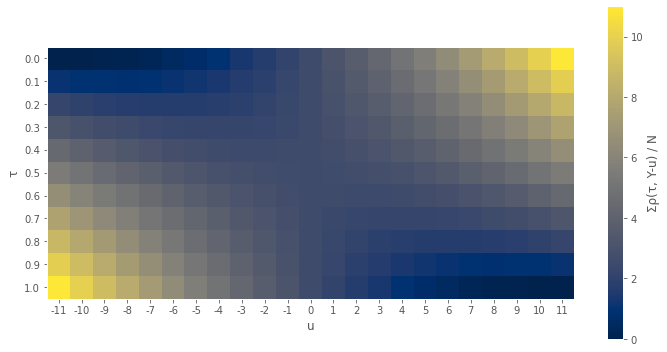

,τ,u,error,count(Y < u),count(Y >= u),count(Y < u) / count(Y)
0,0.0,-11,0.000000,0,21,0.000000
1,0.1,-8,0.942857,2,19,0.095238
2,0.2,-6,1.676190,4,17,0.190476
3,0.3,-4,2.200000,6,15,0.285714
4,0.4,-2,2.514286,8,13,0.380952
5,0.5,0,2.619048,10,11,0.476190
6,0.6,2,2.514286,12,9,0.571429
7,0.7,4,2.200000,14,7,0.666667
8,0.8,6,1.676190,16,5,0.761905
9,0.9,8,0.942857,18,3,0.857143


In [5]:
def __rho_heatmap():
    taus = np.arange(0, 11) / 10.0
    us = np.arange(-11, 12)

    errors = np.zeros(shape=(len(taus), len(us)))
    for i, tau in enumerate(taus):
        for j, u in enumerate(us):
            errors[i, j] = np.sum(rho(tau, Y - u)) / len(Y)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    im = ax.imshow(errors, cmap="cividis")
    plt.colorbar(im, label="Σρ(τ, Y-u) / N")
    ax.grid(False)
    ax.set_xticks(np.arange(len(us)))
    ax.set_xticklabels(us)
    ax.set_xlabel("u")
    ax.set_yticks(np.arange(len(taus)))
    ax.set_yticklabels(taus)
    ax.set_ylabel("τ")
    plt.tight_layout()
    plt.show()

    # Find smallest u for each tau
    data = []
    for tau_idx, tau in enumerate(taus):
        u_idx = np.argmin(errors[tau_idx, :])
        u = us[u_idx]
        error = errors[tau_idx, u_idx]
        data.append({
            "τ": tau,
            "u": u,
            "error": error,
            "count(Y < u)": np.sum(Y < u),
            "count(Y >= u)": np.sum(Y >= u),
            "count(Y < u) / count(Y)": np.sum(Y < u) / len(Y),
        })
    display(pd.DataFrame(data))

__rho_heatmap()

## 参考

- Wikipedia ― [Quantile Regression](https://en.wikipedia.org/wiki/Quantile_regression)
- 知識のサラダボウル ― [Pythonによる分位点回帰 (Quantile Regression)](https://salad-bowl-of-knowledge.github.io/hp/statistics/2020/01/21/quantile_regression.html)
- Robert N. Rodriguez and Yonggang Yao, SASInstitute Inc. ― [Five Things You SHould Know about Quantile Regression](https://support.sas.com/resources/papers/proceedings17/SAS0525-2017.pdf)

# Toy Data を生成して単変量で実装してみる

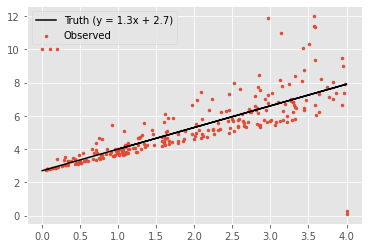

In [6]:
def generate_univariate_data():
    n_samples = 256

    # 真のデータのサンプルを生成
    xₒ = rng.uniform(0, 4, size=n_samples)  # (n_samples,)
    yₒ = np.sum(
        sm.add_constant(xₒ) * np.array([2.7, 1.3]),
        axis=1,
    )

    # カイ二乗分布の形状で誤差を加える
    dist = scipy.stats.chi2(2)
    yₒ += (dist.rvs(size=xₒ.shape[0]) - dist.mean())* (xₒ / 5.0)

    # 標本のいくつかを異常値に差し替える
    xₒ[:5] = (.0, .1, .2, 4., 4.)
    yₒ[:5] = (10, 10, 10, .1, .3)

    return xₒ, yₒ

xₒ, yₒ = generate_univariate_data()

fig, ax = plt.subplots()
ax.plot(xₒ, 1.3 * xₒ + 2.7, color="black", label="Truth (y = 1.3x + 2.7)")
ax.scatter(xₒ, yₒ, color="C0", marker=".", label="Observed")
ax.legend()
plt.show()

In [7]:
# @numba.njit
def ols_loss(X, y, w):  # Σᵢ(xᵢ⋅w - yᵢ)²
    X = np.asarray(X)  # (n_samples, n_weights)
    y = np.asarray(y)  # (n_samples,)
    w = np.asarray(w)  # (n_weights,)
    return np.sum((X @ w - y) ** 2)

np.testing.assert_allclose(
    ols_loss(
        np.asarray([[2.], [4.], [7.]]),
        np.asarray([8., 9., 9.]),
        np.asarray([3.]),
    ),
    157.0
)

CPU times: user 1.59 ms, sys: 3.79 ms, total: 5.38 ms
Wall time: 3.76 ms


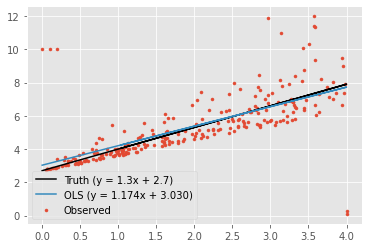

In [8]:
def ols(X, y, *, verbose=False):
    X = np.asarray(X)  # (n_samples, n_weights)
    y = np.asarray(y)  # (n_samples,)
    w0 = rng.uniform(0, 1, size=X.shape[1])
    # print("W₀:", w0)
    res = scipy.optimize.minimize(
        lambda w: ols_loss(X, y, w),
        x0=w0,
        method="nelder-mead",
        options={"disp": verbose},
    )
    if not res.success:
        _logger.warning("not converged")
        return None
    return res.x

%time w_ols = ols(sm.add_constant(xₒ), yₒ)

fig, ax = plt.subplots()
ax.plot(xₒ, 1.3 * xₒ + 2.7, color="black", label="Truth (y = 1.3x + 2.7)")
ax.scatter(xₒ, yₒ, color="C0", marker=".", label="Observed")
ax.plot(xₒ, sm.add_constant(xₒ) @ w_ols, color="C1", label=f"OLS (y = {w_ols[1]:.3f}x + {w_ols[0]:.3f})")
ax.legend()
plt.show()

In [9]:
def quantreg_loss(X, y, W, tau=0.5):
    X = np.asarray(X)  # (n_samples, n_weights)
    y = np.asarray(y)  # (n_samples,)
    W = np.asarray(W)  # (n_weights,)
    delta = np.sum(rho(tau, y - X @ W))
#     print("# δ:", delta)
    return delta

# 単回帰
np.testing.assert_allclose(
    quantreg_loss(
        np.asarray([[2.], [4.], [7.]]),
        np.asarray([8., 9., 9.]),
        np.asarray([3.]),
        tau=0.5,
    ),
    8.5,  # rho(0.5, (8 - 2*3)) + rho(0.5, (9 - 4*3)) + rho(0.5, (9 - 7*3))
)

# 重回帰
np.testing.assert_allclose(
    quantreg_loss(
        X=np.asarray([[2., 4.], [4., 2.], [7., 2.]]),
        y=np.asarray([8., 9., 9.]),
        W=np.asarray([3., 2.]),
        tau=0.5,
    ),
    14.5,  # rho(0.5, (8 - 2*3 - 4*2)) + rho(0.5, (9 - 4*3 - 2*2)) + rho(0.5, (9 - 7*3 - 2*2))
)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


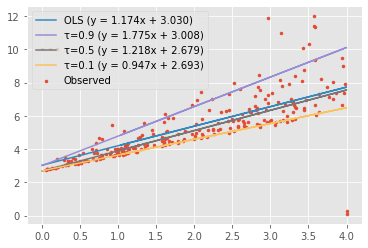

In [10]:
%time
def quantreg(X, y, *, tau=0.5, verbose=False):
    X = np.asarray(X)  # (n_samples, n_weights)
    y = np.asarray(y)  # (n_samples,)
    w0 = rng.uniform(0, 1, size=X.shape[1])
    # print("W₀:", w0)
    res = scipy.optimize.minimize(
        lambda w: quantreg_loss(X, y, w, tau=tau),
        x0=w0,
        method="nelder-mead",
        options={"disp": verbose},
    )
    if not res.success:
        _logger.warning("not converged")
        return None
    return res.x

w_hi_ = quantreg(sm.add_constant(xₒ), yₒ, tau=0.9)
w_mid = quantreg(sm.add_constant(xₒ), yₒ, tau=0.5)
w_low = quantreg(sm.add_constant(xₒ), yₒ, tau=0.1)

fig, ax = plt.subplots()
ax.scatter(xₒ, yₒ, color="C0", marker=".", label="Observed")
ax.plot(xₒ, sm.add_constant(xₒ) @ w_ols, color="C1", label=f"OLS (y = {w_ols[1]:.3f}x + {w_ols[0]:.3f})")
ax.plot(xₒ, sm.add_constant(xₒ) @ w_hi_, color="C2", label=f"τ=0.9 (y = {w_hi_[1]:.3f}x + {w_hi_[0]:.3f})")
ax.plot(xₒ, sm.add_constant(xₒ) @ w_mid, color="C3", label=f"τ=0.5 (y = {w_mid[1]:.3f}x + {w_mid[0]:.3f})")
ax.plot(xₒ, sm.add_constant(xₒ) @ w_low, color="C4", label=f"τ=0.1 (y = {w_low[1]:.3f}x + {w_low[0]:.3f})")
ax.legend()
plt.show()

# 重回帰で試す

In [11]:
@numba.njit
def add_constant(x):
    """Add constant "1" for each sample values."""
    x = np.asarray(x)  # n_samples, n_weights
    return np.concatenate(
        (np.ones(shape=(x.shape[0], 1), dtype=x.dtype), x),
        axis=1,
    )

np.testing.assert_allclose(
    add_constant(np.array([[3.], [4.], [5.]])),
    [[1., 3.], [1., 4.], [1., 5.]],
)

np.testing.assert_allclose(
    add_constant(np.array([[3., 9.], [4., 8.], [5., 7.]])),
    [[1., 3., 9.], [1., 4., 8.], [1., 5., 7.]],
)

if False:
    x = np.array([[3., 9.], [4., 8.], [5., 7.]])
    %timeit add_constant(x)
    %timeit add_constant.py_func(x)
    %timeit sm.add_constant(x)

(1024, 2) (1024,)


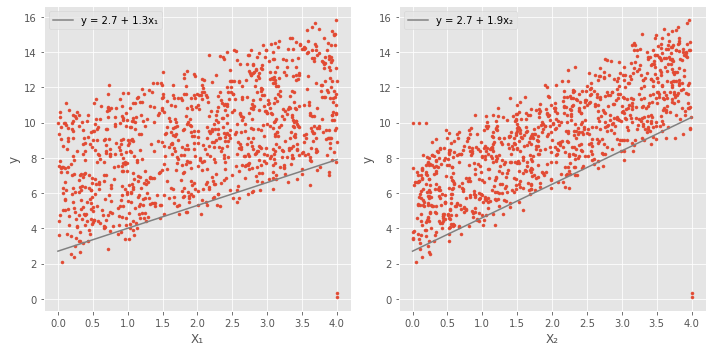

In [259]:
def gen_multivariate_data():
    n_samples = 1024

    # 真のデータとするサンプルを生成
    X = rng.uniform(0, 4, size=(n_samples, 2))
    assert X.shape == (n_samples, 2)
    y = np.sum(
        add_constant(X) * np.array([2.7, 1.3, 1.9]),
        axis=1,
    )
    assert y.shape == (n_samples,)

    # 原点から離れるほど大きくなる誤差を加える
    for i in range(n_samples):
        y[i] += rng.uniform(-1, 1)

    # 標本のいくつかを異常値に差し替える
    X[:5, 0] = (.0, .1, .2, 4., 4.)
    X[:5, 1] = (.0, .1, .2, 4., 4.)
    y[:5] = (10, 10, 10, .1, .3)

    return X, y


X, y = gen_multivariate_data()
print(X.shape, y.shape)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.plot(np.linspace(0, 4), 2.7 + np.linspace(0, 4) * 1.3, color="gray", label="y = 2.7 + 1.3x₁")
ax1.scatter(X[:, 0], y, marker=".")
ax1.set_xlabel("X₁")
ax1.set_ylabel("y")
ax1.legend()
ax2.plot(np.linspace(0, 4), 2.7 + np.linspace(0, 4) * 1.9, color="gray", label="y = 2.7 + 1.9x₂")
ax2.scatter(X[:, 1], y, marker=".")
ax2.set_xlabel("X₂")
ax2.set_ylabel("y")
ax2.legend()
plt.tight_layout()
plt.show()

In [260]:
def quantreg(X, y, *, tau=0.5, verbose=False):
    X = np.asarray(X)  # (n_samples, n_weights)
    y = np.asarray(y)  # (n_samples,)
    w0 = rng.uniform(0, 1, size=X.shape[1])
    # print("W₀:", w0)
    res = scipy.optimize.minimize(
        lambda w: quantreg_loss(X, y, w, tau=tau),
        x0=w0,
        method="nelder-mead",
        options={"disp": verbose},
    )
    if not res.success:
        _logger.warning("not converged")
        return None
    return res.x

w_low = quantreg(add_constant(X), y, tau=0.1)  # (n_weights,)
w_mid = quantreg(add_constant(X), y, tau=0.5)  # (n_weights,)
w_hi_ = quantreg(add_constant(X), y, tau=0.9)  # (n_weights,)

print(f"w_low: {w_low} ... y = {w_low[0]:.2f} + {w_low[1]:.2f}x₁ + {w_low[2]:.2f}x₂")
print(f"w_mid: {w_mid} ... y = {w_mid[0]:.2f} + {w_mid[1]:.2f}x₁ + {w_mid[2]:.2f}x₂")
print(f"w_hi_: {w_hi_} ... y = {w_hi_[0]:.2f} + {w_hi_[1]:.2f}x₁ + {w_hi_[2]:.2f}x₂")

w_low: [1.91306236 1.2996983  1.89940713] ... y = 1.91 + 1.30x₁ + 1.90x₂
w_mid: [2.70982246 1.29762855 1.91098737] ... y = 2.71 + 1.30x₁ + 1.91x₂
w_hi_: [3.55999779 1.2809543  1.88992319] ... y = 3.56 + 1.28x₁ + 1.89x₂


Number of samples under the:
    regression plane with τ=0.1:  101 (9.86%)
    regression plane with τ=0.5:  512 (50.00%)
    regression plane with τ=0.9:  921 (89.94%)


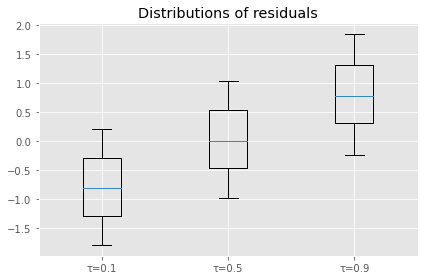

In [271]:
n_low = np.sum(y < add_constant(X) @ w_low)
n_mid = np.sum(y < add_constant(X) @ w_mid)
n_hi_ = np.sum(y < add_constant(X) @ w_hi_)
print("Number of samples under the:")
print(f"    regression plane with τ=0.1: {n_low:>4} ({n_low / len(y):.2%})")
print(f"    regression plane with τ=0.5: {n_mid:>4} ({n_mid / len(y):.2%})")
print(f"    regression plane with τ=0.9: {n_hi_:>4} ({n_hi_ / len(y):.2%})")

data = [
    add_constant(X) @ w_low - y,
    add_constant(X) @ w_mid - y,
    add_constant(X) @ w_hi_ - y,
]
fig, ax = plt.subplots()
ax.boxplot(data, showfliers=False)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["τ=0.1", "τ=0.5", "τ=0.9"])
ax.set_title("Distributions of residuals")
fig.tight_layout()
plt.show()